In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
df=pd.read_csv("power_forecast_302_2010.csv")

In [3]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index("Timestamp",inplace=True)

In [4]:
df

,obs_id,SiteId,Value
Timestamp,,,
2010-01-01 00:00:00,6250827,302,50225.75868
2010-01-01 00:15:00,2892735,302,50225.75868
2010-01-01 00:30:00,963512,302,50225.75868
2010-01-01 00:45:00,2413583,302,50225.75868
2010-01-01 01:00:00,2425214,302,50225.75868
...,...,...,...
2010-12-31 22:45:00,2223969,302,53262.79989
2010-12-31 23:00:00,7055437,302,53262.79989
2010-12-31 23:15:00,7449100,302,53262.79989


In [5]:
df['obs_id'].nunique() #all are different or unique

29280

In [6]:
df.drop('obs_id',axis=1,inplace=True)

In [7]:
df['SiteId'].nunique() #all are same

1

In [8]:
df.drop('SiteId',axis=1,inplace=True)

In [9]:
df

,Value
Timestamp,
2010-01-01 00:00:00,50225.75868
2010-01-01 00:15:00,50225.75868
2010-01-01 00:30:00,50225.75868
2010-01-01 00:45:00,50225.75868
2010-01-01 01:00:00,50225.75868
...,...
2010-12-31 22:45:00,53262.79989
2010-12-31 23:00:00,53262.79989
2010-12-31 23:15:00,53262.79989


In [10]:
df=(df.resample('15min').mean())
df=pd.DataFrame(df)

In [11]:
period = 29280 #df.shape[0]
pd.date_range('2010-01-01 00:00:00', freq='15min', periods=period)

DatetimeIndex(['2010-01-01 00:00:00', '2010-01-01 00:15:00',
               '2010-01-01 00:30:00', '2010-01-01 00:45:00',
               '2010-01-01 01:00:00', '2010-01-01 01:15:00',
               '2010-01-01 01:30:00', '2010-01-01 01:45:00',
               '2010-01-01 02:00:00', '2010-01-01 02:15:00',
               ...
               '2010-11-01 21:30:00', '2010-11-01 21:45:00',
               '2010-11-01 22:00:00', '2010-11-01 22:15:00',
               '2010-11-01 22:30:00', '2010-11-01 22:45:00',
               '2010-11-01 23:00:00', '2010-11-01 23:15:00',
               '2010-11-01 23:30:00', '2010-11-01 23:45:00'],
              dtype='datetime64[ns]', length=29280, freq='15T')

In [12]:
df.isnull().sum()/df.shape[0]*100

Value    16.449772
dtype: float64

In [13]:
#df['Value'] = df['Value'].fillna(df['Value'].rolling(50,min_periods=1).mean())
df= df.interpolate();
print(df)

                           Value
Timestamp                       
2010-01-01 00:00:00  50225.75868
2010-01-01 00:15:00  50225.75868
2010-01-01 00:30:00  50225.75868
2010-01-01 00:45:00  50225.75868
2010-01-01 01:00:00  50225.75868
...                          ...
2010-12-31 22:45:00  53262.79989
2010-12-31 23:00:00  53262.79989
2010-12-31 23:15:00  53262.79989
2010-12-31 23:30:00  53262.79989
2010-12-31 23:45:00  53262.79989

[35040 rows x 1 columns]


In [14]:
df.isnull().sum()/df.shape[0]*100

Value    0.0
dtype: float64

In [15]:
df.shape

(35040, 1)

<AxesSubplot:xlabel='Timestamp'>

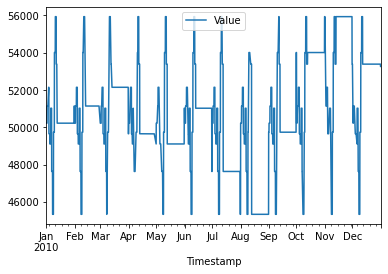

In [16]:
df.plot()

In [17]:
from statsmodels.tsa.stattools import adfuller
# ADF Test
#Augmented Dickey–Fuller test
result = adfuller( df['Value'].values, autolag='AIC')

print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')
if result[1] <= 0.05:
    print("It's stationary")
else:
    print("It's not stationary")

ADF Statistic: -5.554839778135462
p-value: 1.5895375870079543e-06
Critial Values:
   1%, -3.4305366588415316
Critial Values:
   5%, -2.8616224985980065
Critial Values:
   10%, -2.566813911410397
It's stationary


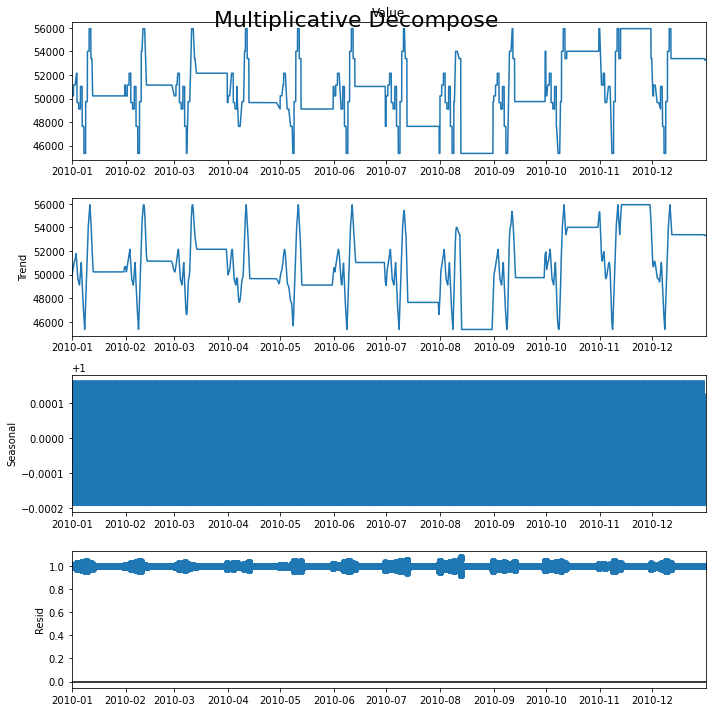

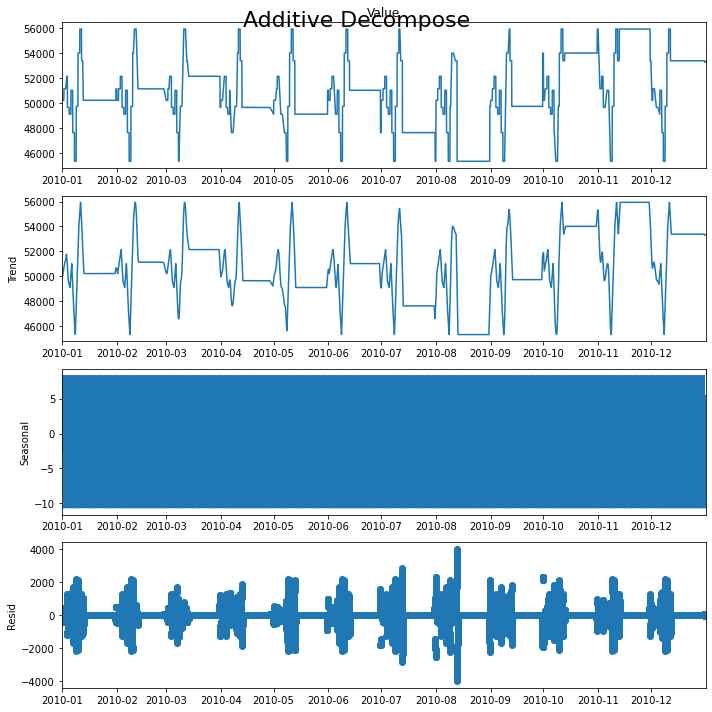

In [18]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Multiplicative Decomposition 
result_mul = seasonal_decompose(df['Value'], model='multiplicative', extrapolate_trend='freq',period=96)

# Additive Decomposition
result_add = seasonal_decompose(df['Value'], model='additive', extrapolate_trend='freq',period=96)

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

In [19]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split

train,test = train_test_split(df,train_size=0.8)

In [20]:
model = pm.auto_arima(train, start_p=7, max_p=10, seasonal=False, trace=True, random=True)  # random search
forecasts = model.predict(test.shape[0])

Performing stepwise search to minimize aic
 ARIMA(7,1,2)(0,0,0)[0] intercept   : AIC=366235.555, Time=12.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=366223.914, Time=0.78 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=366224.500, Time=1.48 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=366224.518, Time=1.66 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=366221.933, Time=0.33 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=366213.519, Time=10.82 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=366215.470, Time=19.70 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=366215.421, Time=21.72 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=366225.351, Time=2.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=366225.307, Time=2.20 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=366216.105, Time=19.16 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=366211.518, Time=3.67 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=366222.536, Time=0.99 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=366222.518, Time=0.79 sec


In [21]:
y= df['Value']

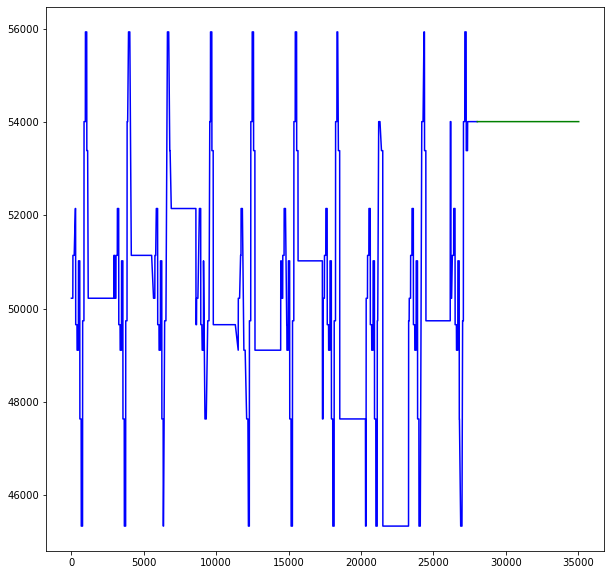

In [22]:
# Visualize forecast(blue line-train, green line- forecasts)

x = np.arange(df.shape[0])
plt.plot(x[:train.shape[0]],train,c='blue')
plt.plot(x[train.shape[0]:],forecasts,c='green')
plt.show()

In [23]:
forecasts

array([54012.0115    , 54012.0115    , 54012.0115    , ...,
       54012.01150006, 54012.01150006, 54012.01150006])

In [24]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

model = ARIMA(train, order=(0,1,0)) 
model_fit = model.fit()
output = model_fit.predict(start=train.shape[0],end=(y.shape[0]-1),dynamic=True)
output

2010-10-20 00:00:00    0.135074
2010-10-20 00:15:00    0.135074
2010-10-20 00:30:00    0.135074
2010-10-20 00:45:00    0.135074
2010-10-20 01:00:00    0.135074
                         ...   
2010-12-31 22:45:00    0.135074
2010-12-31 23:00:00    0.135074
2010-12-31 23:15:00    0.135074
2010-12-31 23:30:00    0.135074
2010-12-31 23:45:00    0.135074
Freq: 15T, Length: 7008, dtype: float64

In [25]:
rmse=mean_squared_error(test,output)**0.5

In [26]:
output_1 = model_fit.forecast(len(test))
print("RMSE is = ", mean_squared_error(test,output_1[0])**0.5)

RMSE is =  2760.5309802139236


In [27]:
model = ARIMA(train, order=(1,1,0)) 
model_fit = model.fit()
output =model_fit.predict(start=train.shape[0],end=(y.shape[0]-1),dynamic=True)
output

2010-10-20 00:00:00    0.134114
2010-10-20 00:15:00    0.135067
2010-10-20 00:30:00    0.135074
2010-10-20 00:45:00    0.135074
2010-10-20 01:00:00    0.135074
                         ...   
2010-12-31 22:45:00    0.135074
2010-12-31 23:00:00    0.135074
2010-12-31 23:15:00    0.135074
2010-12-31 23:30:00    0.135074
2010-12-31 23:45:00    0.135074
Freq: 15T, Length: 7008, dtype: float64

In [28]:
rmse=mean_squared_error(test,output)**0.5

In [34]:
output_2 = model_fit.forecast(len(test))
print("RMSE is = ", mean_squared_error(test,output_2[0])**0.5)

RMSE is =  2760.531417064681


In [35]:
prediction_range1 = output_1[2].T
prediction_range2 = output_2[2].T

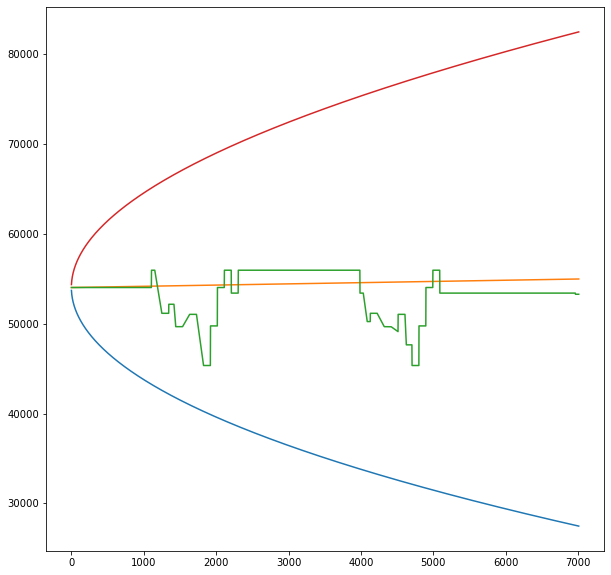

In [36]:
plt.plot(range(prediction_range1[0].shape[0]),prediction_range1[0])
plt.plot(range(prediction_range1[0].shape[0]),output_1[0])
plt.plot(range(prediction_range1[0].shape[0]),test)
plt.plot(range(prediction_range1[1].shape[0]),prediction_range1[1])

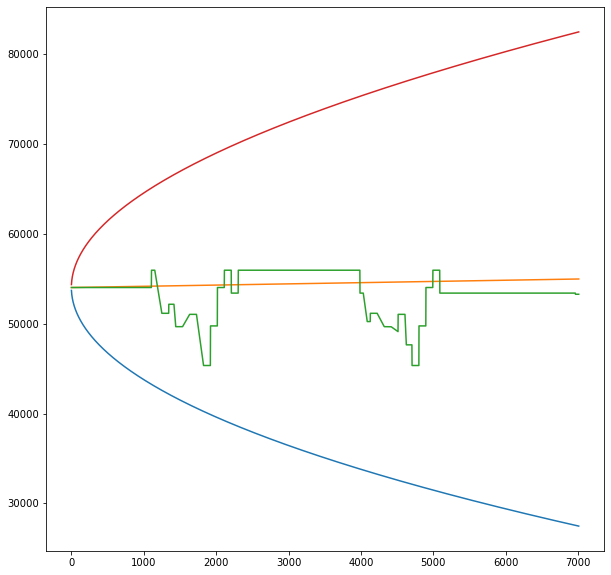

In [37]:
plt.plot(range(prediction_range2[0].shape[0]),prediction_range2[0])
plt.plot(range(prediction_range2[0].shape[0]),output_2[0])
plt.plot(range(prediction_range2[0].shape[0]),test)
plt.plot(range(prediction_range2[1].shape[0]),prediction_range2[1])